In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [14]:
# Database connection
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'ecommerce'
DB_USER = 'postgres'
DB_PASSWORD = '18*DhyaneshvaR'  # Update with your password

# Create connection string
connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_string)

print("Database connection established")

Database connection established


In [15]:
# Load all data
users_df = pd.read_sql("SELECT * FROM users", engine)
products_df = pd.read_sql("SELECT * FROM products WHERE is_active = true", engine)
events_df = pd.read_sql("SELECT * FROM events", engine)

print(f"Data Summary:")
print(f"Users: {len(users_df):,}")
print(f"Products: {len(products_df):,}")
print(f"Events: {len(events_df):,}")
print(f"\nDate Range: {events_df['created_at'].min()} to {events_df['created_at'].max()}")

Data Summary:
Users: 112
Products: 104
Events: 12,728

Date Range: 2025-11-18 02:34:00.930000 to 2025-12-17 13:48:49.122000


In [16]:
# Event type distribution
print("Event Distribution:")
print(events_df['event_type'].value_counts())
print("\n" + "="*50 + "\n")

# Users by role
print("Users by Role:")
print(users_df['role'].value_counts())
print("\n" + "="*50 + "\n")

# Products by category
print("Products by Category:")
print(products_df['category'].value_counts().sort_values(ascending=False))

Event Distribution:
event_type
view           6232
click          4278
add_to_cart    1938
purchase        280
Name: count, dtype: int64


Users by Role:
role
buyer     101
seller     11
Name: count, dtype: int64


Products by Category:
category
Electronics               13
Other                     11
Clothing                  10
Toys & Games              10
Books                     10
Automotive                10
Beauty & Personal Care    10
Sports & Outdoors         10
Food & Beverages          10
Home & Garden             10
Name: count, dtype: int64


Conversion Funnel:
Views:        6,232
Clicks:       4,278 (68.6% of views)
Add to Cart:  1,938 (45.3% of clicks)
Purchases:    280 (14.4% of cart)

Overall Conversion Rate: 4.49%


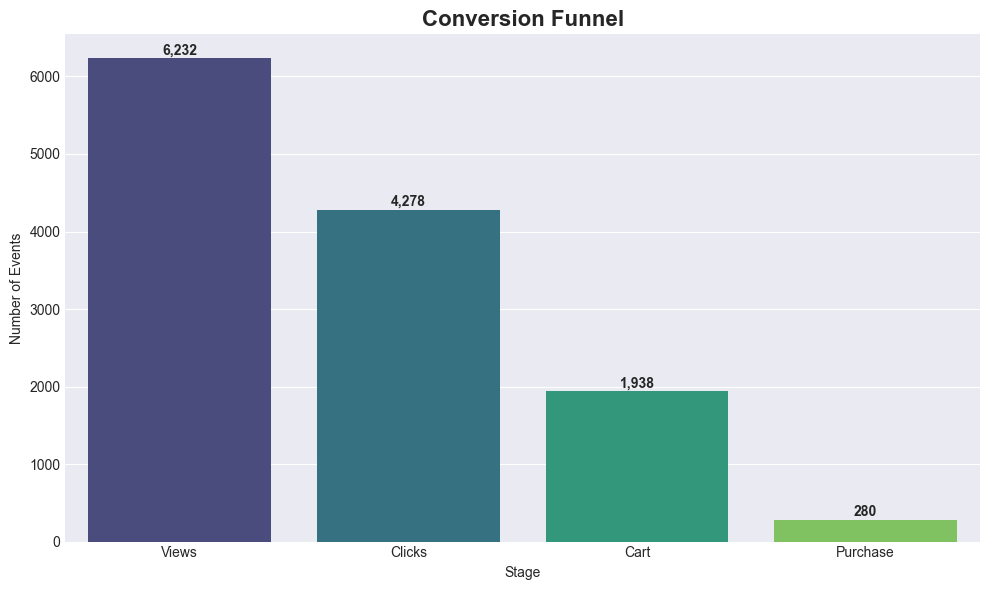

In [17]:
# Calculate conversion funnel
funnel = events_df['event_type'].value_counts().sort_index()

views = funnel.get('view', 0)
clicks = funnel.get('click', 0)
carts = funnel.get('add_to_cart', 0)
purchases = funnel.get('purchase', 0)

print("Conversion Funnel:")
print(f"Views:        {views:,}")
print(f"Clicks:       {clicks:,} ({clicks/views*100:.1f}% of views)")
print(f"Add to Cart:  {carts:,} ({carts/clicks*100:.1f}% of clicks)")
print(f"Purchases:    {purchases:,} ({purchases/carts*100:.1f}% of cart)")
print(f"\nOverall Conversion Rate: {purchases/views*100:.2f}%")

# Visualize funnel
funnel_data = pd.DataFrame({
    'Stage': ['Views', 'Clicks', 'Cart', 'Purchase'],
    'Count': [views, clicks, carts, purchases]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_data, x='Stage', y='Count', palette='viridis')
plt.title('Conversion Funnel', fontsize=16, fontweight='bold')
plt.ylabel('Number of Events')
plt.ticklabel_format(style='plain', axis='y')
for i, v in enumerate(funnel_data['Count']):
    plt.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

User Activity Statistics:
count    101.000000
mean     126.019802
std       68.505471
min       32.000000
25%       73.000000
50%      100.000000
75%      196.000000
max      274.000000
Name: total_events, dtype: float64

Users with purchases: 93 / 101
Average purchases per buyer: 3.01


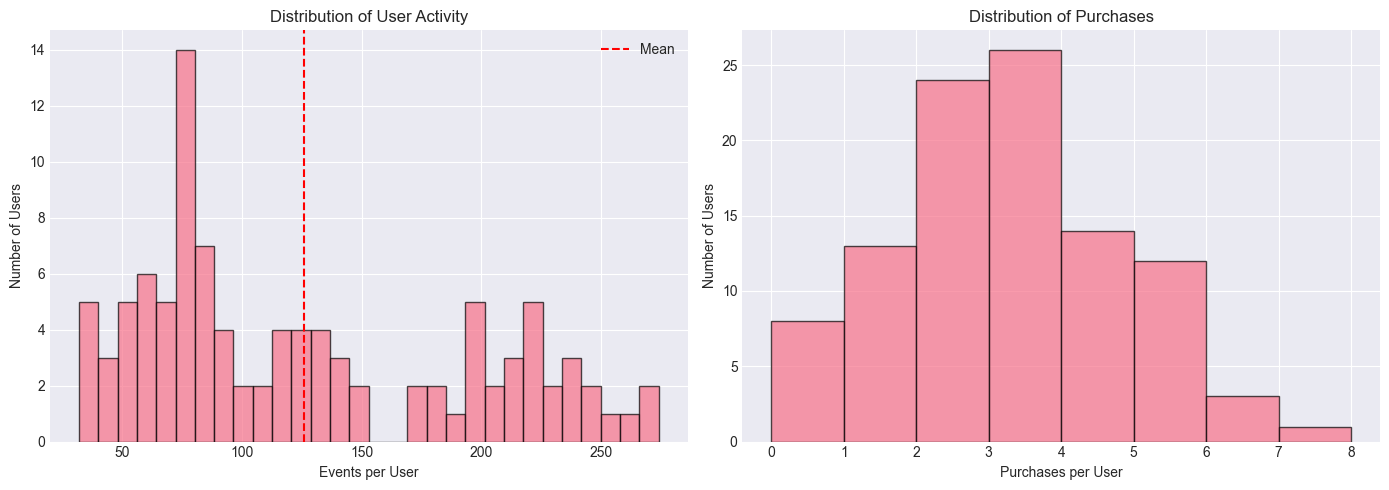

In [18]:
# User engagement metrics
user_activity = events_df.groupby('user_id').agg({
    'event_type': 'count',
    'created_at': ['min', 'max']
}).reset_index()

user_activity.columns = ['user_id', 'total_events', 'first_event', 'last_event']
user_activity['days_active'] = (user_activity['last_event'] - user_activity['first_event']).dt.days + 1

# Add purchase count
purchases_per_user = events_df[events_df['event_type'] == 'purchase'].groupby('user_id').size()
user_activity['purchases'] = user_activity['user_id'].map(purchases_per_user).fillna(0).astype(int)

print("User Activity Statistics:")
print(user_activity['total_events'].describe())
print(f"\nUsers with purchases: {(user_activity['purchases'] > 0).sum()} / {len(user_activity)}")
print(f"Average purchases per buyer: {user_activity[user_activity['purchases'] > 0]['purchases'].mean():.2f}")

# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Events per user
axes[0].hist(user_activity['total_events'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Events per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of User Activity')
axes[0].axvline(user_activity['total_events'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Purchases per user
axes[1].hist(user_activity['purchases'], bins=range(0, user_activity['purchases'].max()+2), edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Purchases per User')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Purchases')

plt.tight_layout()
plt.show()

User Segments:
segment
Power Buyer       80
Buyer             13
Window Shopper     4
Casual Visitor     3
Browser            1
Name: count, dtype: int64


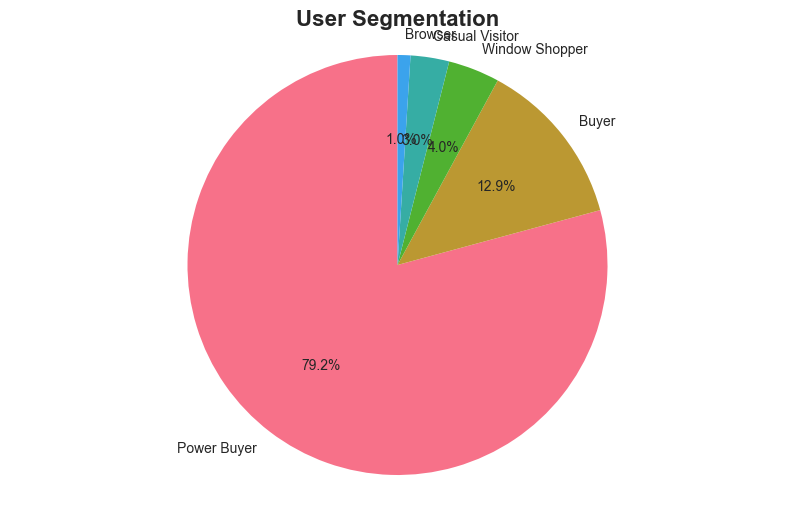

In [20]:
# Segment users by behavior
def segment_user(row):
    if row['purchases'] >= 2:
        return 'Power Buyer'
    elif row['purchases'] == 1:
        return 'Buyer'
    elif row['total_events'] >= 100:
        return 'Browser'
    elif row['total_events'] >= 50:
        return 'Window Shopper'
    else:
        return 'Casual Visitor'

user_activity['segment'] = user_activity.apply(segment_user, axis=1)

print("User Segments:")
print(user_activity['segment'].value_counts())

# Visualize
plt.figure(figsize=(10, 6))
segment_counts = user_activity['segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('User Segmentation', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

In [21]:
# Product engagement
product_stats = events_df.groupby('product_id').agg({
    'event_type': 'count',
    'user_id': 'nunique'
}).reset_index()
product_stats.columns = ['product_id', 'total_events', 'unique_users']

# Add event type breakdown
for event_type in ['view', 'click', 'add_to_cart', 'purchase']:
    event_counts = events_df[events_df['event_type'] == event_type].groupby('product_id').size()
    product_stats[event_type] = product_stats['product_id'].map(event_counts).fillna(0).astype(int)

# Merge with product details
product_stats = product_stats.merge(products_df[['id', 'name', 'category', 'price']], 
                                     left_on='product_id', right_on='id', how='left')

# Calculate conversion rate
product_stats['conversion_rate'] = (product_stats['purchase'] / product_stats['view'] * 100).round(2)

print("Product Statistics:")
print(product_stats[['view', 'click', 'add_to_cart', 'purchase']].describe())

# Top 10 most viewed products
print("\nTop 10 Most Viewed Products:")
print(product_stats.nlargest(10, 'view')[['name', 'category', 'view', 'purchase', 'conversion_rate']])

Product Statistics:
             view       click  add_to_cart    purchase
count  104.000000  104.000000   104.000000  104.000000
mean    59.923077   41.134615    18.634615    2.692308
std      8.959122    6.800996     4.159578    2.393669
min     40.000000   22.000000     9.000000    0.000000
25%     53.000000   37.000000    16.000000    1.000000
50%     60.000000   40.000000    18.000000    2.000000
75%     65.250000   45.250000    21.000000    4.000000
max     86.000000   59.000000    33.000000   10.000000

Top 10 Most Viewed Products:
                                                 name          category  view  \
69  Amul Dark Chocolate: Assorted Pack Of 55%,75% ...  Food & Beverages    86   
67                   Sprite Soft Drink - Lime, 180Ml   Food & Beverages    82   
24  Minecraft Java & Bedrock Edition Bundle PC Cod...      Toys & Games    80   
98   Safari Pentagon Pro 8 Wheels Checkin Trolley ...             Other    76   
29       Gucci Women's Jumbo GG Denim-jacquard Jac

Power Law (80/20 Rule):
Top 20% of products (20 products) account for 23.6% of views


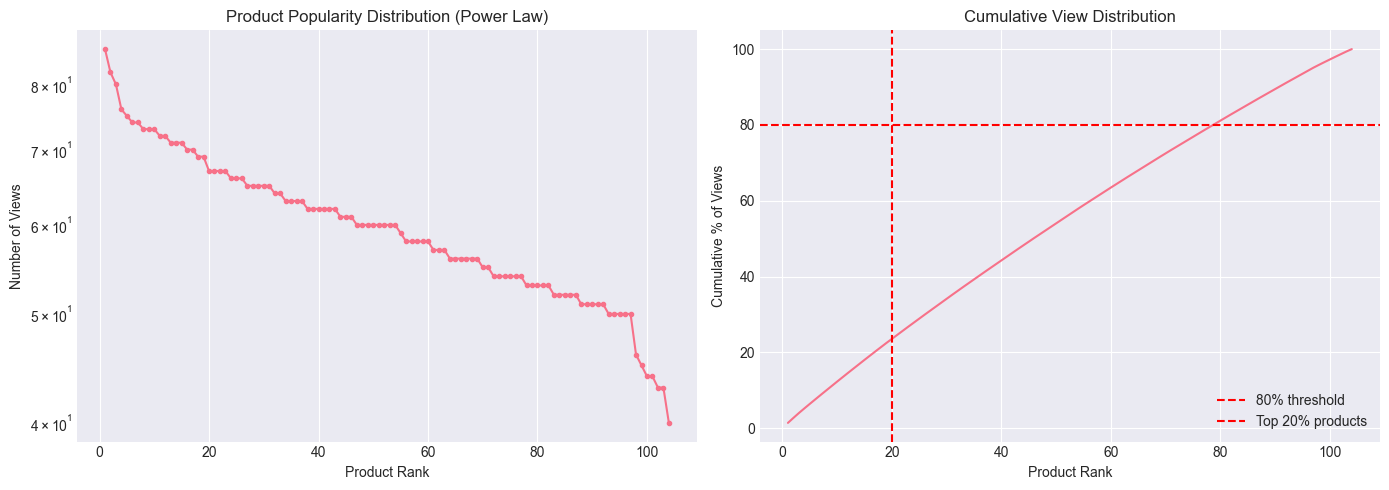

In [23]:
# Sort products by views
product_views = product_stats.sort_values('view', ascending=False).reset_index(drop=True)
product_views['rank'] = range(1, len(product_views) + 1)
product_views['cumulative_views'] = product_views['view'].cumsum()
product_views['cumulative_pct'] = product_views['cumulative_views'] / product_views['view'].sum() * 100

# Check 80/20 rule
top_20_pct = int(len(product_views) * 0.2)
views_by_top_20 = product_views.iloc[:top_20_pct]['view'].sum()
total_views = product_views['view'].sum()

print(f"Power Law (80/20 Rule):")
print(f"Top 20% of products ({top_20_pct} products) account for {views_by_top_20/total_views*100:.1f}% of views")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rank vs Views
axes[0].plot(product_views['rank'], product_views['view'], marker='o', markersize=3)
axes[0].set_xlabel('Product Rank')
axes[0].set_ylabel('Number of Views')
axes[0].set_title('Product Popularity Distribution (Power Law)')
axes[0].set_yscale('log')

# Cumulative distribution
axes[1].plot(product_views['rank'], product_views['cumulative_pct'])
axes[1].axhline(y=80, color='r', linestyle='--', label='80% threshold')
axes[1].axvline(x=top_20_pct, color='r', linestyle='--', label='Top 20% products')
axes[1].set_xlabel('Product Rank')
axes[1].set_ylabel('Cumulative % of Views')
axes[1].set_title('Cumulative View Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

Category Performance:
event_type              add_to_cart  click  purchase  view  conversion_rate
category                                                                   
Food & Beverages                213    486        42   721             5.83
Electronics                     229    477        24   695             3.45
Books                           201    431        40   623             6.42
Automotive                      203    447        27   618             4.37
Beauty & Personal Care          186    430        37   614             6.03
Other                           186    404        21   612             3.43
Clothing                        168    420        21   603             3.48
Toys & Games                    186    405        26   602             4.32
Sports & Outdoors               193    397        25   583             4.29
Home & Garden                   173    381        17   561             3.03


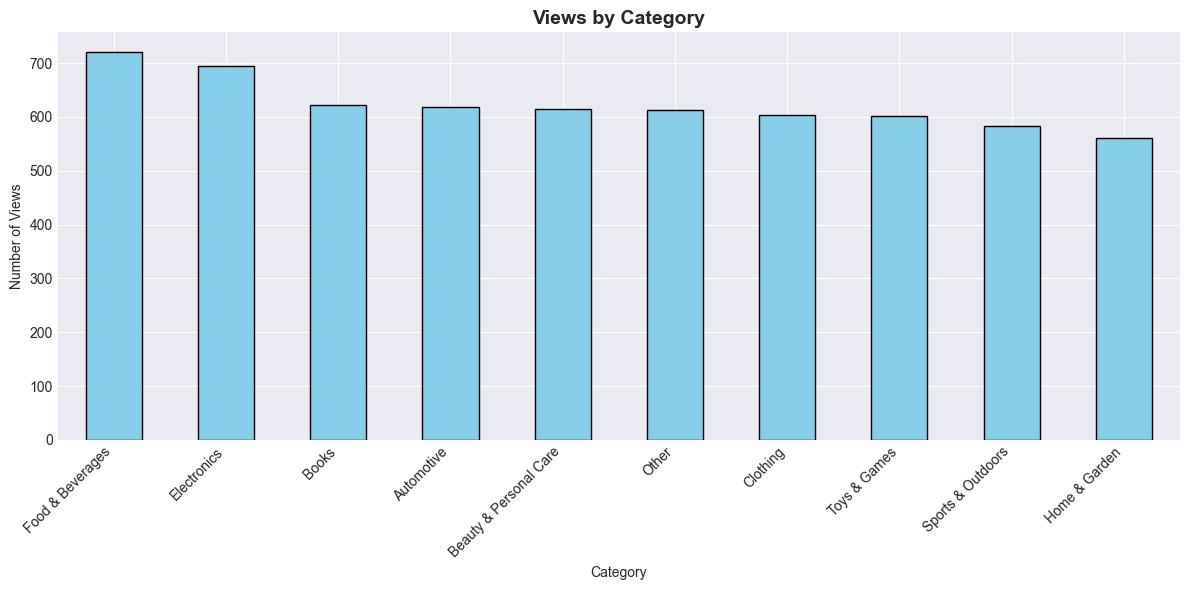

In [24]:
# Events by category
category_stats = events_df.merge(products_df[['id', 'category']], 
                                  left_on='product_id', right_on='id', how='left')

category_summary = category_stats.groupby(['category', 'event_type']).size().unstack(fill_value=0)
category_summary['conversion_rate'] = (category_summary['purchase'] / category_summary['view'] * 100).round(2)

print("Category Performance:")
print(category_summary.sort_values('view', ascending=False))

# Visualize
plt.figure(figsize=(12, 6))
category_summary.sort_values('view', ascending=False)['view'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Views by Category', fontsize=14, fontweight='bold')
plt.ylabel('Number of Views')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

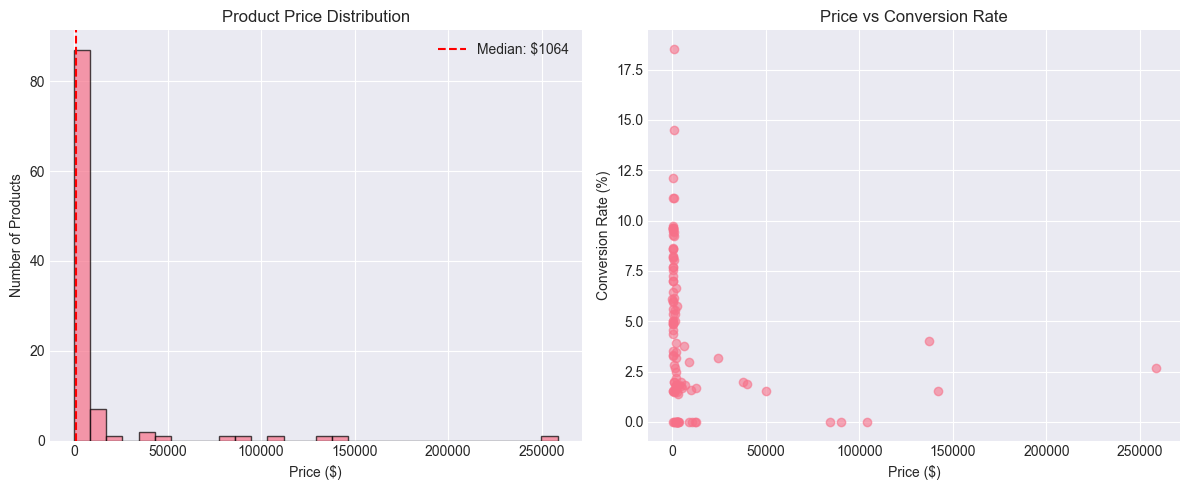


Conversion Rate by Price Bucket:
              view  purchase  conversion_rate
price_bucket                                 
$0-500        2106       145         6.861471
$500-1K       1051        78         7.276471
$1K-5K        1932        39         2.067879
$5K-50K        793        13         1.581429
$50K+          350         5         1.368333


In [25]:
# Price distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(products_df['price'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Price ($)')
plt.ylabel('Number of Products')
plt.title('Product Price Distribution')
plt.axvline(products_df['price'].median(), color='red', linestyle='--', label=f'Median: ${products_df["price"].median():.0f}')
plt.legend()

# Price vs Conversion Rate
plt.subplot(1, 2, 2)
plt.scatter(product_stats['price'], product_stats['conversion_rate'], alpha=0.6)
plt.xlabel('Price ($)')
plt.ylabel('Conversion Rate (%)')
plt.title('Price vs Conversion Rate')
plt.tight_layout()
plt.show()

# Price bucket analysis
product_stats['price_bucket'] = pd.cut(product_stats['price'], 
                                        bins=[0, 500, 1000, 5000, 50000, 300000],
                                        labels=['$0-500', '$500-1K', '$1K-5K', '$5K-50K', '$50K+'])

price_bucket_stats = product_stats.groupby('price_bucket').agg({
    'view': 'sum',
    'purchase': 'sum',
    'conversion_rate': 'mean'
})

print("\nConversion Rate by Price Bucket:")
print(price_bucket_stats)

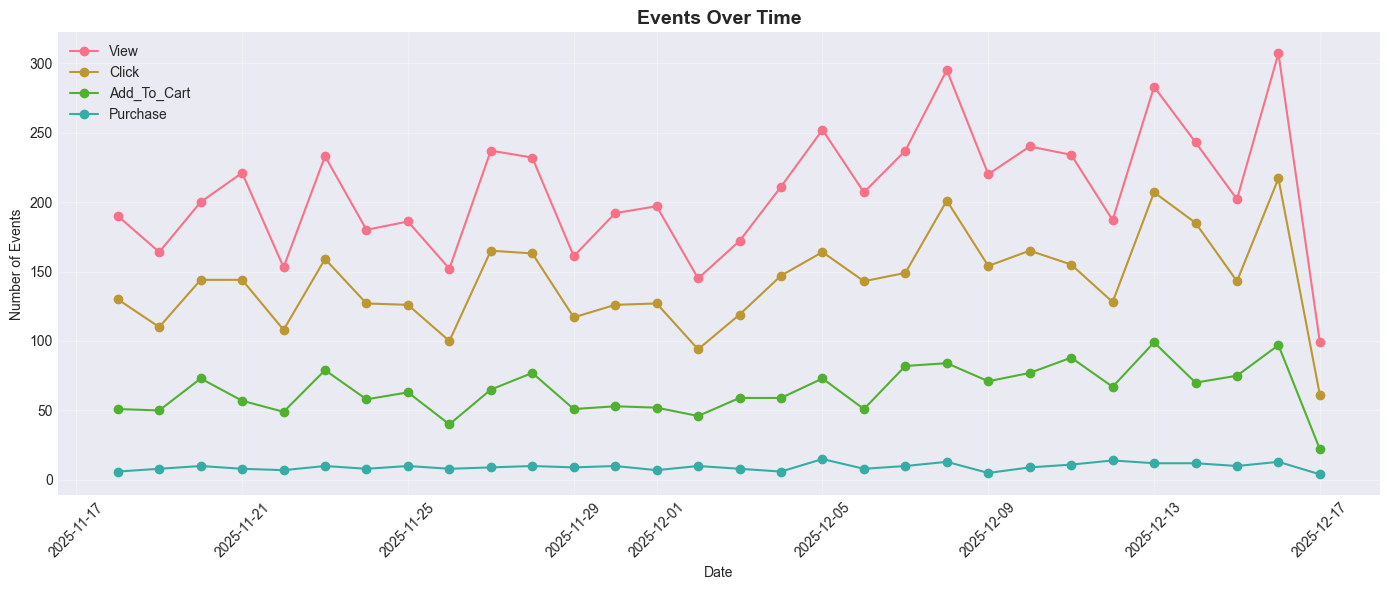

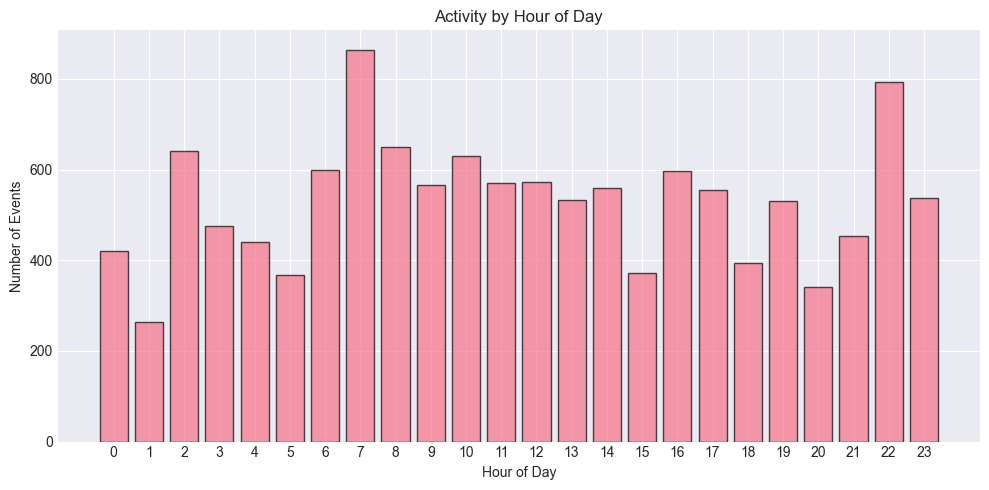

In [26]:
# Convert to datetime
events_df['date'] = pd.to_datetime(events_df['created_at']).dt.date
events_df['hour'] = pd.to_datetime(events_df['created_at']).dt.hour
events_df['day_of_week'] = pd.to_datetime(events_df['created_at']).dt.day_name()

# Events over time
daily_events = events_df.groupby(['date', 'event_type']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
for event_type in ['view', 'click', 'add_to_cart', 'purchase']:
    if event_type in daily_events.columns:
        plt.plot(daily_events.index, daily_events[event_type], marker='o', label=event_type.title())

plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Events Over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Hour of day analysis
hourly_events = events_df.groupby('hour').size()

plt.figure(figsize=(10, 5))
plt.bar(hourly_events.index, hourly_events.values, edgecolor='black', alpha=0.7)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.title('Activity by Hour of Day')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [27]:
# Users with multiple purchases
purchase_events = events_df[events_df['event_type'] == 'purchase']
repeat_buyers = purchase_events.groupby('user_id').size()

print("Repeat Purchase Analysis:")
print(f"Total buyers: {len(repeat_buyers)}")
print(f"One-time buyers: {(repeat_buyers == 1).sum()} ({(repeat_buyers == 1).sum()/len(repeat_buyers)*100:.1f}%)")
print(f"Repeat buyers: {(repeat_buyers > 1).sum()} ({(repeat_buyers > 1).sum()/len(repeat_buyers)*100:.1f}%)")
print(f"\nPurchases per buyer:")
print(repeat_buyers.value_counts().sort_index())

# Time between purchases
purchase_events_sorted = purchase_events.sort_values(['user_id', 'created_at'])
purchase_events_sorted['next_purchase'] = purchase_events_sorted.groupby('user_id')['created_at'].shift(-1)
purchase_events_sorted['days_to_next'] = (purchase_events_sorted['next_purchase'] - 
                                           purchase_events_sorted['created_at']).dt.days

print(f"\nDays Between Purchases (for repeat buyers):")
print(purchase_events_sorted['days_to_next'].dropna().describe())

Repeat Purchase Analysis:
Total buyers: 93
One-time buyers: 13 (14.0%)
Repeat buyers: 80 (86.0%)

Purchases per buyer:
1    13
2    24
3    26
4    14
5    12
6     3
7     1
Name: count, dtype: int64

⏱️ Days Between Purchases (for repeat buyers):
count    187.000000
mean       5.475936
std        5.576758
min        0.000000
25%        1.000000
50%        4.000000
75%        9.000000
max       24.000000
Name: days_to_next, dtype: float64


In [28]:
print("="*60)
print("KEY INSIGHTS")
print("="*60)

print(f"\nDATASET OVERVIEW:")
print(f"  • Total Events: {len(events_df):,}")
print(f"  • Active Users: {events_df['user_id'].nunique():,} buyers")
print(f"  • Active Products: {events_df['product_id'].nunique():,} / {len(products_df):,}")
print(f"  • Date Range: {(events_df['created_at'].max() - events_df['created_at'].min()).days} days")

print(f"\nCONVERSION METRICS:")
print(f"  • Overall Conversion: {purchases/views*100:.2f}%")
print(f"  • View → Click: {clicks/views*100:.1f}%")
print(f"  • Click → Cart: {carts/clicks*100:.1f}%")
print(f"  • Cart → Purchase: {purchases/carts*100:.1f}%")

print(f"\nUSER BEHAVIOR:")
print(f"  • Avg events per user: {user_activity['total_events'].mean():.1f}")
print(f"  • Users who purchased: {(user_activity['purchases'] > 0).sum()}/{len(user_activity)}")
print(f"  • Repeat buyers: {(repeat_buyers > 1).sum()}/{len(repeat_buyers)} ({(repeat_buyers > 1).sum()/len(repeat_buyers)*100:.1f}%)")

print(f"\nPRODUCT INSIGHTS:")
print(f"  • Top 20% products = {views_by_top_20/total_views*100:.1f}% of views")
print(f"  • Categories with highest conversion: {category_summary.nlargest(3, 'conversion_rate').index.tolist()}")
print(f"  • Price range: ${products_df['price'].min():.0f} - ${products_df['price'].max():.0f}")

print(f"\nDATA QUALITY:")
print(f"  • Products with 0 views: {(product_stats['view'] == 0).sum()}")
print(f"  • Users with 0 purchases: {(user_activity['purchases'] == 0).sum()}")

print("\n" + "="*60)

KEY INSIGHTS

DATASET OVERVIEW:
  • Total Events: 12,728
  • Active Users: 101 buyers
  • Active Products: 104 / 104
  • Date Range: 29 days

CONVERSION METRICS:
  • Overall Conversion: 4.49%
  • View → Click: 68.6%
  • Click → Cart: 45.3%
  • Cart → Purchase: 14.4%

USER BEHAVIOR:
  • Avg events per user: 126.0
  • Users who purchased: 93/101
  • Repeat buyers: 80/93 (86.0%)

PRODUCT INSIGHTS:
  • Top 20% products = 23.6% of views
  • Categories with highest conversion: ['Books', 'Beauty & Personal Care', 'Food & Beverages']
  • Price range: $45 - $258525

DATA QUALITY:
  • Products with 0 views: 0
  • Users with 0 purchases: 8

